# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [258]:
# built-in libraries
import os
import sys
from itertools import combinations
import importlib
import time

# external dependencies
import pandas as pd
import numpy as onp
from tqdm.notebook import tqdm


import multidms
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**First, we'll define a few global variables.**

In [259]:
# The substitution column to use from the functional score dataframes
substitution_column = 'aa_substitutions_reference'

# The column providing which individual conditions each variant observation was derived from.
experiment_column = 'homolog_exp'

**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [260]:
fit_params = {
    # pre-processing params
    "scale_counts" : False,
    "fs_scaling_group_column" : "homolog_exp",
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "agg_variants" : True,
    "sample" : False, #5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "include_stop_variants" : True,
    "shift_func_score_target_nonref" : False,
    # conditions to include in fit
    "reference_condition" : "Delta-2-1",
    "conditions" : ["Delta-2-1", "Omicron_BA.1-2-1"]
}

## Pre-Proccessing

**Read in the dms data and list all available experimental conditions**

In [261]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


**Query the conditions to be included in a fit**

In [262]:
func_score_data = func_score_data.query(
    f"{experiment_column}.isin({fit_params['conditions']})"
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
10,2022-06-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1,Lib-2_2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-2_2022-06-22_thaw-...,library pre_samp...,140643,Omicron_BA.1,Omicron_BA.1-2-1


In [263]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])

  0%|          | 0/2 [00:00<?, ?it/s]

**Optionally subset the variants**

In [264]:
if fit_params["sample"]:
    func_score_df = func_score_df.sample(fit_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [265]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/182229 [00:00<?, ?it/s]

**Optionally, scale the counts**

In [266]:
# TODO re-write and make function
# def normalize_by_freq()?
if fit_params['scale_counts']:
    dfs = []
    for (h, hdf) in func_score_df.groupby(fit_params["fs_scaling_group_column"]):
        n_post_counts = sum(hdf['post_count'])
        if 'Delta' in h:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        else:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        hdf['orig_post_count'] = hdf['post_count']
        hdf['post_count'] *= scaling_factor
        hdf['post_count_wt'] *= scaling_factor
        print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

        # Recompute enrichment ratios with new counts
        hdf['pre_count_ps'] = hdf['pre_count'] + fit_params["pseudocount"]
        hdf['post_count_ps'] = hdf['post_count'] + fit_params["pseudocount"]
        hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + fit_params["pseudocount"]
        hdf['post_count_wt_ps'] = hdf['post_count_wt'] + fit_params["pseudocount"]

        total_pre_count = sum(hdf['pre_count_ps'])
        total_post_count = sum(hdf['post_count_ps'])

        hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
        hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
        hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
        hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

        hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
        hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
        hdf['e'] = hdf['var_e'] / hdf['wt_e']
        #hdf.dropna(subset=['e'], inplace=True)
        hdf['func_score'] = hdf['e'].apply(lambda x: math.log(x, 2))
        dfs.append(hdf)
    func_score_df = pd.concat(dfs)

**Drop all variants with pre-counts below a threshold.**

In [267]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= fit_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {fit_params['min_pre_counts']} counts before selection, and were filtered out")

Of 169856 variants, 16326 had fewer than 100 counts before selection, and were filtered out


**Optionally throw all variants with stop codons.**

In [268]:
# results["include_stop_variants"] = True
if not fit_params["include_stop_variants"]:
    stop_variants = [idx for idx, row in func_score_df.iterrows() if "*" in row[substitution_column]]
    func_score_df = func_score_df.drop(stop_variants)

**Optionally, clip the target functional scores**

In [269]:
if fit_params['clip_target']:
    func_score_df["func_score"] = func_score_df["func_score"].clip(*fit_params["clip_target"])

In [270]:
func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1, inplace=True)
func_score_df.rename({"homolog_exp":"condition"}, axis=1, inplace=True)

In [271]:
func_score_df.head()

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-2,2021-10-28_thaw-1_VSVG_control_1,2021-11-28_thaw-1_no-antibody_control_1,CCGAGTAATCCAATAA,-0.4039,0.0005,10237,7909,1909460,1951855,0.5,3,D251A M1235V,2,D253A M1237V,20,Delta,1,Delta-2-1
1,Lib-2,2021-10-28_thaw-1_VSVG_control_1,2021-11-28_thaw-1_no-antibody_control_1,TAAGGACACTCACAAA,-0.3398,0.0005,8528,6888,1909460,1951855,0.5,3,H623L A1014V T1115M,3,H625L A1016V T1117M,20,Delta,1,Delta-2-1
2,Lib-2,2021-10-28_thaw-1_VSVG_control_1,2021-11-28_thaw-1_no-antibody_control_1,ATATTAGTTTATGCCT,-0.1499,0.0005,7979,7351,1909460,1951855,0.5,2,G767H,1,G769H,20,Delta,1,Delta-2-1
3,Lib-2,2021-10-28_thaw-1_VSVG_control_1,2021-11-28_thaw-1_no-antibody_control_1,GAAGATCACTGGTCGA,-0.1554,0.0005,7956,7302,1909460,1951855,0.5,3,P26T S475D,2,P26T S477D,20,Delta,1,Delta-2-1
4,Lib-2,2021-10-28_thaw-1_VSVG_control_1,2021-11-28_thaw-1_no-antibody_control_1,CAAGTGGGTAAATGAT,-1.0530,0.0009,7340,3616,1909460,1951855,0.5,4,G75W D176E P320Q H1099R,4,G75W D178E P322Q H1101R,20,Delta,1,Delta-2-1


## `MultiDmsData`

In [272]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [460]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("colorblind"),
    reference="Delta-2-1"
)

100%|█████████████████████████████████████████████████████████████| 66785/66785 [02:30<00:00, 443.32it/s]


In [461]:
data.site_map

,Delta-2-1,Omicron_BA.1-2-1
1015,A,A
1188,E,E
1027,T,T
1016,A,A
1191,K,K
...,...,...
16,V,V
3,V,V
42,V,V
6,V,V


In [462]:
data.mutations[:5]

('M1F', 'M1I', 'M1K', 'M1L', 'M1T')

In [463]:
data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-2-1,times_seen_Omicron_BA.1-2-1
0,M1F,M,1,F,2.0,0.0
1,M1I,M,1,I,3.0,5.0
2,M1K,M,1,K,3.0,0.0
3,M1L,M,1,L,4.0,0.0
4,M1T,M,1,T,0.0,7.0


In [464]:
data.variants_df.head() # TODO, we should probably drop allowed_variant, yes?

,condition,aa_substitutions,weight,func_score,allowed_variant,var_wrt_ref
0,Delta-2-1,,4344,-0.158614,True,
1,Delta-2-1,A1015D,1,-1.676400,True,A1015D
2,Delta-2-1,A1015D E1188Q,1,-1.118400,True,A1015D E1188Q
3,Delta-2-1,A1015D T1027S,1,-3.500000,True,A1015D T1027S
4,Delta-2-1,A1016S,3,-0.222967,True,A1016S


In [465]:
data.conditions

('Delta-2-1', 'Omicron_BA.1-2-1')

In [466]:
data.reference

'Delta-2-1'

In [467]:
data.binarymaps # this is poorly named, 'y' also exists here

{'Delta-2-1': <binarymap.binarymap.BinaryMap at 0x7f8a55f7bb50>,
 'Omicron_BA.1-2-1': <binarymap.binarymap.BinaryMap at 0x7f8a55f7ba00>}

In [468]:
data.non_identical_sites

frozendict.frozendict({'Delta-2-1': [], 'Omicron_BA.1-2-1': array([655, 484, 440, 679, 681, 373, 477, 950, 954, 856, 417, 796, 501,
       764, 496, 375, 493, 446, 452,  67,  95, 981, 547, 212, 969, 339,
       156, 498, 371, 505,  19])})

In [469]:
data.non_identical_mutations

frozendict.frozendict({'Delta-2-1': '', 'Omicron_BA.1-2-1': 'H655Y E484A N440K N679K R681H S373P S477N N950D Q954H N856K K417N D796Y N501Y N764K G496S S375F Q493R G446S R452L A67V T95I L981F T547K L212I N969K G339D G156E Q498R S371L Y505H R19T'})

## `MultiDmsModel`

In short the `MultiDmsModel` object initialization includes:
   1. initialize attributes
   2. initialize params depending on model composits chosen
   3. compile model composition

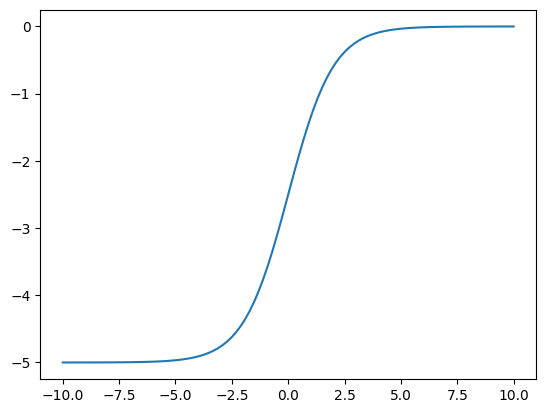

In [475]:
x = jnp.array(onp.linspace(-10, 10, 100))
custom_params = {"ge_scale":jnp.array([5]) , "ge_bias":jnp.array([-5])}
y = multidms.model.sigmoidal_global_epistasis(custom_params, x)
plt.plot(x, y)

In [513]:
# import pprint
# pprint.PrettyPrinter(moi.params)

In [499]:
models = defaultdict(list)
for ge_func in ["sigmoid", "softplus", "identity"]:  
    for output_act in ["identity", "softplus"]:
        imodel = multidms.MultiDmsModel(
                data,
                latent_model="phi",
                epistatic_model=ge_func,
                output_activation=output_act
        )
        imodel.fit(lasso_shift=1e-5, maxiter=5000)
        models["ge_func"].append(ge_func)
        models["output_act"].append(output_act)
        models["model"].append(imodel)
models_df = pd.DataFrame(models)
models_df

,ge_func,output_act,model
0,sigmoid,identity,<multidms.model.MultiDmsModel object at 0x7f8a...


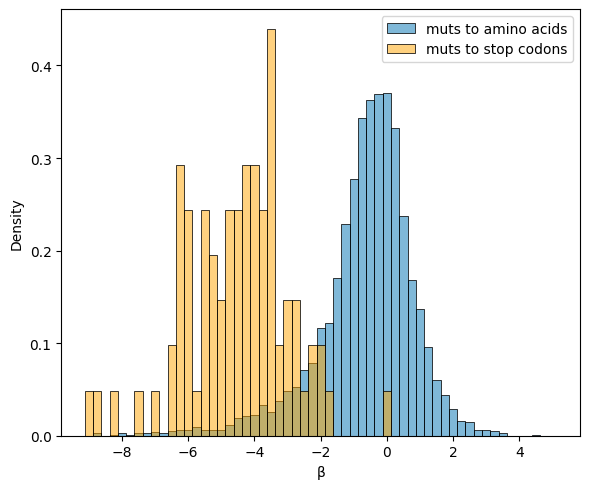

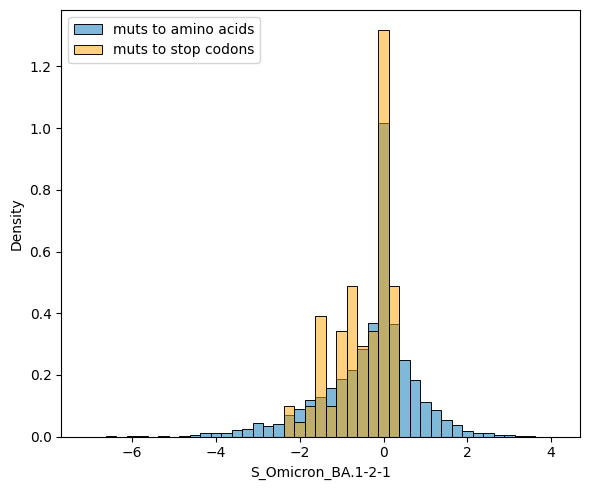

In [507]:
moi = models_df.loc[0, "model"]
# fig, ax = moi.plot_pred_accuracy(show=True, alpha=0.01)
# fig, ax = moi.plot_epistasis(show=True, alpha=0.01)
fig, ax = moi.plot_param_hist('β', show=True, times_seen_threshold=3)
fig, ax = moi.plot_param_hist('S_Omicron_BA.1-2-1', show=True, times_seen_threshold=3)

In [449]:
moi.params.keys()

dict_keys(['C_Delta-2-1', 'C_Omicron_BA.1-2-1', 'C_ref', 'S_Delta-2-1', 'S_Omicron_BA.1-2-1', 'α', 'β', 'γ_Delta-2-1', 'γ_Omicron_BA.1-2-1'])

In [480]:
moi.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-2-1,times_seen_Omicron_BA.1-2-1,β,S_Delta-2-1,F_Delta-2-1,S_Omicron_BA.1-2-1,F_Omicron_BA.1-2-1
0,M1F,M,1,F,2.0,0.0,-5.293447,0.0,-3.344660,0.000000,-3.344660
1,M1I,M,1,I,3.0,5.0,-3.489875,0.0,-2.313251,0.025431,-2.290849
2,M1K,M,1,K,3.0,0.0,-5.546229,0.0,-3.409753,0.000000,-3.409753
3,M1L,M,1,L,4.0,0.0,-6.550193,0.0,-3.561890,0.000000,-3.561890
4,M1T,M,1,T,0.0,7.0,-3.000635,0.0,-1.858834,-2.353959,-3.361717
...,...,...,...,...,...,...,...,...,...,...,...
9650,S1252T,S,1252,T,19.0,117.0,-0.218789,0.0,-0.039308,0.060946,-0.024959
9651,S1252V,S,1252,V,14.0,84.0,0.488678,0.0,0.087573,-0.036420,0.082845
9652,S1252W,S,1252,W,2.0,24.0,2.944229,0.0,0.208025,-2.750501,0.044288
9653,S1252Y,S,1252,Y,34.0,97.0,0.889106,0.0,0.130173,0.071029,0.136181


In [ ]:
# moi.data.variants_df

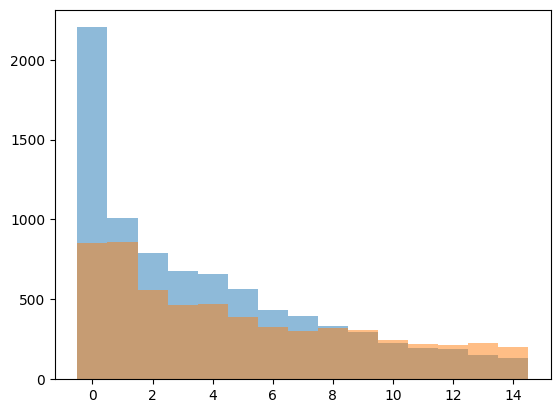

In [496]:
bins = onp.arange(-0.5, 15, 1)
plt.hist(moi.mutations_df["times_seen_Delta-2-1"], bins=bins, alpha=0.5)
plt.hist(moi.mutations_df["times_seen_Omicron_BA.1-2-1"], bins=bins, alpha=0.5)
plt.show()

In [489]:
moi.params["β"].shape

(9655,)

In [490]:
1200 * 20

24000

In [491]:
moi.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-2-1,times_seen_Omicron_BA.1-2-1,β,S_Delta-2-1,F_Delta-2-1,S_Omicron_BA.1-2-1,F_Omicron_BA.1-2-1
0,M1F,M,1,F,2.0,0.0,-5.293447,0.0,-3.344660,0.000000,-3.344660
1,M1I,M,1,I,3.0,5.0,-3.489875,0.0,-2.313251,0.025431,-2.290849
2,M1K,M,1,K,3.0,0.0,-5.546229,0.0,-3.409753,0.000000,-3.409753
3,M1L,M,1,L,4.0,0.0,-6.550193,0.0,-3.561890,0.000000,-3.561890
4,M1T,M,1,T,0.0,7.0,-3.000635,0.0,-1.858834,-2.353959,-3.361717
...,...,...,...,...,...,...,...,...,...,...,...
9650,S1252T,S,1252,T,19.0,117.0,-0.218789,0.0,-0.039308,0.060946,-0.024959
9651,S1252V,S,1252,V,14.0,84.0,0.488678,0.0,0.087573,-0.036420,0.082845
9652,S1252W,S,1252,W,2.0,24.0,2.944229,0.0,0.208025,-2.750501,0.044288
9653,S1252Y,S,1252,Y,34.0,97.0,0.889106,0.0,0.130173,0.071029,0.136181
